In [1]:
#!/usr/bin/env python3

import os, sys
sys.path.append('../')
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('../')

try:
    import mplhep as hep
    hep.style.use("ATLAS")
except:
    pass
delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')



Welcome to JupyROOT 6.30/06


True

In [2]:
inputFile = '../pp2chi0chi0_minimalH_scan_jets/Events/run_01/ddmH_mS_2000_m1_979_dm_90_delphes_events.root'
# inputFile = '../DelphesLLP/test.root'

In [6]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")

nevts = tree.GetEntries()
massList = []
pTList = []
for ievt in range(nevts):
    tree.GetEntry(ievt)

    pS = np.array([0.0,0.0,0.0,0.0])
    for p in tree.llpParticlesA:    
        pS += np.array([p.E,p.Px,p.Py,p.Pz])
    for p in tree.llpParticlesB:    
        pS += np.array([p.E,p.Px,p.Py,p.Pz])

    massList.append(np.sqrt(pS[0]**2 - np.dot(pS[1:4],pS[1:4])))
    pTList.append(np.sqrt(np.dot(pS[1:3],pS[1:3])))

f.Close()

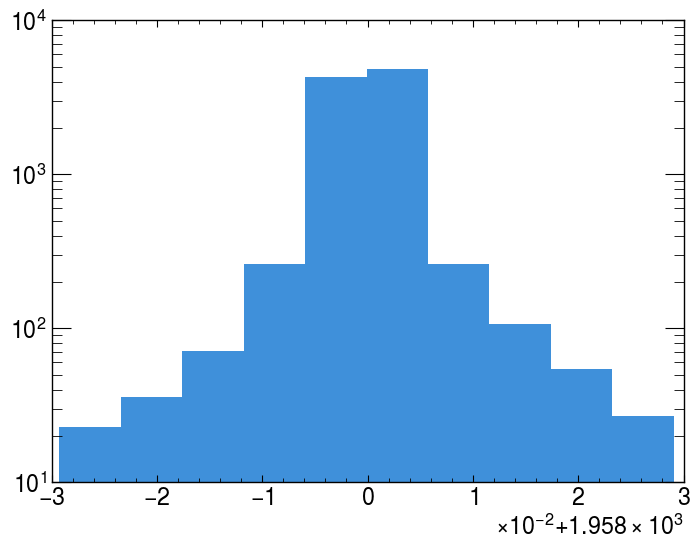

In [7]:
plt.hist(massList,bins=10)
plt.yscale('log')
plt.show()

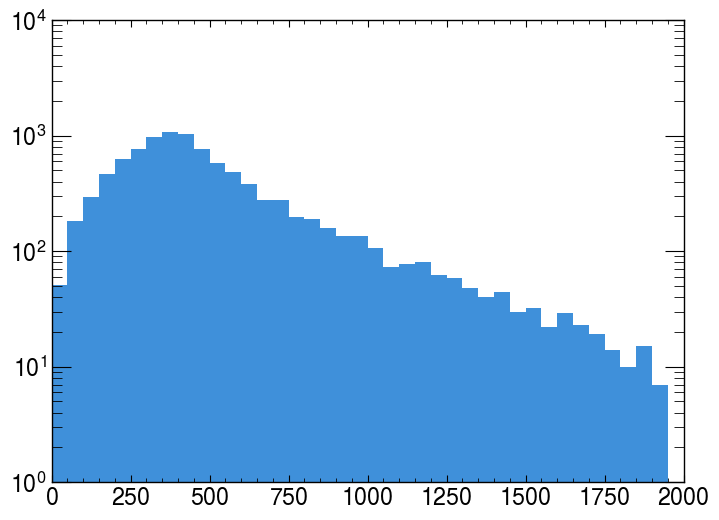

In [14]:
plt.hist(pTList,bins=np.arange(0.,2000.,50.))
plt.yscale('log')
plt.xlim(0.,2000.0)
plt.show()